In [70]:
#Kmeans를 tensorflow로 구현 => 행렬이해에 도움
import tensorflow as tf
sess = tf.Session()
val = [0,2,3]
val = tf.tile(val,[5]) #타일링 5번반복하며 만들어짐
print('홑일때', sess.run(val))

홑일때 [0 2 3 0 2 3 0 2 3 0 2 3 0 2 3]


In [71]:
val = [[1,1,1],[2,2,2],[3,3,3]] #3*3 -> 5*2 로타일링
val = tf.tile(val,[5,2]) #행으로 5번, 곱 열로 2번 곱
print('2차원일때', sess.run(val))

2차원일때 [[1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]
 [1 1 1 1 1 1]
 [2 2 2 2 2 2]
 [3 3 3 3 3 3]]


In [72]:
input_vecs = [[1.,2.],[2.,1.],[-2.,-1.]]
print('차원 확대', sess.run(tf.expand_dims(input_vecs,1))) #2차원 데이터 -> 3차원 데이터로 확장
#1*3*2로 차원이 확대되었다.

차원 확대 [[[ 1.  2.]]

 [[ 2.  1.]]

 [[-2. -1.]]]


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()
iris = datasets.load_iris()

In [74]:
#군집분석으로 target은 필요업당
num_pts = len(iris.data) #데이터갯수
num_feats = len(iris.data[0]) #변수갯수
print(num_pts, num_feats)
k = 3 #3개로 군집하겠다.
generations = 10 #epochs를 의미한다. 세대

#데이터 입력공간
data_points = tf.Variable(iris.data) #variable에는 가중치가 들어간다. (데이터 양만큼 들어간다. 150*4)
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype=tf.int64)) #150개를 전부 0으로 생성 cluster label을 넣으려고 만듬

rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] for _ in range(k)]) #3번 돌아가면서, _횟수로만 k를 쓰겠다.
#iris 데이터 중에서 하나씩을 세번 골라라 -> 중심값을 선정하기 위해서
#[[각변수4개들어있음],[],[]] 형태를 갖게된다. 랜덤초이스를 3번해서 중심값을 선정하였다.
#kmeans(k값, 중심값)
print(rand_starts) #중심값을 랜덤으로 설정
centroids = tf.Variable(rand_starts)

#150개 만큼 복사해서 만듬 -> 3*4 -> 150*3*4 (reshape으로 명확하게 모양을 지정해준다.)
#150*4의 기존데이터과 랜덤한 중심값3개와 각각 거리를 구해야 하기 때문에
#150*4 를 통째로 복사해서 3개의 큰열을 만들면 위의 150*3*4의 중심값 3개와 거리값 계산이 가능하다.
centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts,1]), [num_pts, k, num_feats])
point_matrix = tf.reshape(tf.tile(data_points, [1,k]), [num_pts, k, num_feats]) #data point에 대해서 반복하라.
#150*4를 3번 복사해서 150*3*4를 만듬
distance = tf.reduce_sum(tf.square(point_matrix - centroid_matrix), axis=2) #0,1,2 2=말단끼리 빼라, 빼서 제곱한것을 모두더함
#거리값은 150*3으로 나온다.(마지막열(2) 빼고 나서 제곱하고 더하니까.)
centroid_group = tf.argmin(distance, 1) #최소값
#kmeans 중심값과의 거리를 재는것이 목적

150 4
[[5.  3.5 1.6 0.6]
 [6.8 2.8 4.8 1.4]
 [6.9 3.2 5.7 2.3]]


In [75]:
c = tf.constant([[1,2,3,4],[5,6,7,8],[4,3,2,1]])
sess.run(tf.unsorted_segment_sum(c, tf.constant([0,1,0]), num_segments=2))
#unsorted_segment_sum - 데이터에대해 세그먼트 별로 합계를 줬는데 
#그룹이 2개고 그 그룹을 0,1,0 번으로 주겠다. 같은그룹을 합쳐라
#그룹변 합계를 낼 때 쓰는 함수이다.

array([[5, 5, 5, 5],
       [5, 6, 7, 8]])

In [79]:
def data_group_avg(group_ids, data):
    #중심값을 재계산 하는 함수
    sum_total = tf.unsorted_segment_sum(data, group_ids, 3) #요소별 합계가 된다.(그룹별로 3덩어리가 나온다.)
    num_total = tf.unsorted_segment_sum(tf.ones_like(data), group_ids, 3) #ones_like - 1로 생성
    avg_by_group = sum_total/num_total
    #중심값이 된다.
    return (avg_by_group)

#그룹번호, 데이터
print(sess.run(centroid_group))
print(sess.run(data_points))
means = data_group_avg(centroid_group, data_points) #중심값/실데이터값
#중심값이 계산된 값으로 변경되었다. / 그룹번호도 변경되었다.
update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))
init = tf.global_variables_initializer()
sess.run(init)
for i in range(generations):
    print('세대 : {}, 전체 : {}'.format(i, generations))
    _, centriod_group_count = sess.run([update, centroid_group])
    group_count =[]
    for ix in range(k):
        group_count.append(np.sum(centriod_group_count==ix))
    print('그룹별 수 : {}'.format(group_count))

[centers, assignments] = sess.run([centroids, cluster_labels])
print(centers, assignments)
#정답은 50,50,50

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 

In [46]:
def most_common(my_list):
    #센터값, 그룹할당 번호, set=중복되지 않는 key값 가장큰값
    return (max(set(my_list), key = my_list.count))

label0 = most_common(list(assignments[0:50])) #한그룹
label1 = most_common(list(assignments[50:100]))
label2 = most_common(list(assignments[100:150]))
print(label0, label1, label2)

group0_count = np.sum(assignments[0:50]==label0)
group1_count = np.sum(assignments[50:100]==label1)
group2_count = np.sum(assignments[100:150]==label2)
print(group0_count, group1_count, group2_count)

accuracy = (group0_count + group1_count + group2_count)/150
print('Accuracy : {:.2}'.format(accuracy))

1 1 0
0 48 36
Accuracy : 0.56


In [80]:
from tensorflow.python.framework import ops
import csv
import random
ops.reset_default_graph()

In [81]:
response = 6
batch_size = 50
symmetry = ['rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h']

In [82]:
def print_board(board):
    symbols = ['o',' ','x']
    board_plus1 = [int(x) + 1 for x in board]
    print(' '+ symbols[board_plus1[0]]+' | '+symbols[board_plus1[1]]+' | '+symbols[board_plus1[2]])
    print(' '+ symbols[board_plus1[3]]+' | '+symbols[board_plus1[4]]+' | '+symbols[board_plus1[5]])
    print(' '+ symbols[board_plus1[6]]+' | '+symbols[board_plus1[7]]+' | '+symbols[board_plus1[8]])

In [83]:
#data augmentation하는 부분(증감)
#0 1 2
#3 4 5
#6 7 8

# data augmentation(증강 => 이미지) # 동일한 경우의 수 늘림
def get_symmetry(board, response, transformation):
    #보드 9개 response 1개
    if transformation =='rotate180':
        #180도를 돌려야 한다면
        new_response = 8-response #새로운 위치는 8-response다.
        return board[::-1], new_response
    elif transformation == 'rotate90':
        #시계방향으로 돌린다는 뜻
        #6 3 0
        #7 4 1
        #8 5 2
        new_response = [6,3,0,7,4,1,8,5,2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return [value for item in tuple_board for value in item], new_response
    elif transformation == 'rotate270':
        new_response = [2,5,8,1,4,7,0,3,6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return [value for item in tuple_board for value in item], new_response
    elif transformation == 'flip_v':
        new_response = [6,7,8,3,4,5,0,1,2].index(response)
        return board[6:9]+board[3:6]+board[0:3], new_response
    elif transformation == 'flip_h':
        new_response = [2,1,0,5,4,3,8,7,6].index(response)
        new_board = board[::-1]
        return new_board[6:9]+new_board[3:6]+new_board[0:3], new_response
    else :
        raise ValueError('해당하는 경우 없음')   

In [84]:
def get_moves_from_csv(csv_file):
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]], int(row[9])))
            #10개 들어와서 [[],1] : 2개
    return moves

def get_rand_move(moves, n=1, rand_transforms=2):
    #데이터 증강 흐름
    board, response = random.choice(moves)
    #보드9개 response1개
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        board, response = get_symmetry(board, response, random_transform)
    return board, response
    
moves = get_moves_from_csv('tic_moves.csv')
train_length = 560
train_set = []
print(train_set)

for t in range(train_length):
    train_set.append(get_rand_move(moves))
print(len(train_set))
test_board = [-1,0,0,1,-1,-1,0,0,1]
train_set = [x for x in train_set if x[0] != test_board]

[]
560


In [85]:
import tensorflow as tf
def init_weights(shape):
    #가중치 초기화를 하기 위해서 하였다.
    return (tf.Variable(tf.random_normal(shape)))
def model(X, A1, A2, bias1, bias2):
    # ?*9  9*81 -> 확대 
    layer1 = tf.sigmoid(tf.add(tf.matmul(X,A1), bias1))
    layer2 = tf.add(tf.matmul(layer1,A2), bias2)
    return layer2

X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
Y = tf.placeholder(dtype=tf.int32, shape=[None])

A1 = init_weights([9,81])
bias1 = init_weights([81])
A2 = init_weights([81,9])
bias2 = init_weights([9])
model_output = model(X, A1, A2, bias1, bias2) #예측한놈 - 9개의 확률로 나옴

In [ ]:
import numpy as np
#확률로 다중분류기로 9개의 말자리중에 어떤자리가 될지를 확률값으로 말해준다.
#분류시의 cost function
#지도학습 (라벨은 결정이 되어있다.)
#cross_entropy - 두 데이터의 확률관계를 이용해서 복잡도를 표현한다. (log값 이용)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = model_output, labels=Y))
#learning rate를 주고 0.025 미니마이즈 중
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)
prediction = tf.argmax(model_output, 1) #확률이 가장큰놈 - 말위치가됨
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
loss_vec = []
for i in range(50000):
    #10000번 돌면서 학습할때 target을 1
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
    #훈련받을 데이터가 stochastic(확률적으로)하게 mini-batch(전체중에 50개만 뽑아서)로 선택된다. -> 지역해 없고 속도 빠르다.
    batch_data = [train_set[i] for i in rand_indices]
    #print(len(batch_data))
    x_input = [x[0] for x in batch_data]
    #print(x_input) #50*9
    y_target = np.array([y[1] for y in batch_data])
    #print(y_target) #50*1
    sess.run(train_step, feed_dict={X:x_input, Y:y_target})
    temp_loss = sess.run(loss, feed_dict={X:x_input, Y:y_target})
    loss_vec.append(temp_loss)
    if i%500 ==0:
        #500번마다 메세지를 출력
        print('반복횟수 : '+str(i)+'Loss'+str(temp_loss))

반복횟수 : 0Loss8.49772
반복횟수 : 500Loss1.8740561
반복횟수 : 1000Loss1.6210823
반복횟수 : 1500Loss1.3739865
반복횟수 : 2000Loss1.2092212
반복횟수 : 2500Loss1.2993684
반복횟수 : 3000Loss1.2426858
반복횟수 : 3500Loss1.3082433
반복횟수 : 4000Loss0.99111396
반복횟수 : 4500Loss1.1372944
반복횟수 : 5000Loss1.1760782
반복횟수 : 5500Loss0.9567798
반복횟수 : 6000Loss0.9416491
반복횟수 : 6500Loss0.75842667
반복횟수 : 7000Loss0.7606417
반복횟수 : 7500Loss0.90712076
반복횟수 : 8000Loss0.9168369
반복횟수 : 8500Loss0.78217286
반복횟수 : 9000Loss0.8903214
반복횟수 : 9500Loss0.94074446
반복횟수 : 10000Loss0.72612494
반복횟수 : 10500Loss0.67806005
반복횟수 : 11000Loss0.7937207
반복횟수 : 11500Loss0.6459642
반복횟수 : 12000Loss0.7049648
반복횟수 : 12500Loss0.84382117
반복횟수 : 13000Loss0.7082331
반복횟수 : 13500Loss0.55357283
반복횟수 : 14000Loss0.66831857
반복횟수 : 14500Loss0.6063504
반복횟수 : 15000Loss0.7982518
반복횟수 : 15500Loss0.6571955
반복횟수 : 16000Loss0.6393363
반복횟수 : 16500Loss0.5158881
반복횟수 : 17000Loss0.5775148
반복횟수 : 17500Loss0.6282716
반복횟수 : 18000Loss0.53511655
반복횟수 : 18500Loss0.62965584
반복횟수 : 19000Loss0.5660018


In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_vec, 'k-', label='loss')
plt.title('Loss(MSE)')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()
test_boards = [test_board]
feed_dict = {X:test_boards}
logits = sess.run(model_output, feed_dict = feed_dict)
predictions = sess.run(prediction, feed_dict = feed_dict)
print(predictions)

In [ ]:
def check(board):
    #게임의 승패를 결정하는것 - 종료조건
    #컴퓨터에 인공지능을 달아주는 것
    wins = [[0,1,2],[3,4,5],[6,7,8],[1,4,7],[2,5,8],[0,4,8],[2,4,6]] #이기는 인덱스의 경우의수
    for i in range(len(wins)):
        if board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==1.:
            return (1)
        elif board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==-1.:
            return (-1)
    return(0)

In [ ]:
#유저인 경우 = 1, 컴퓨터인 경우 = -1
game_tracker = [0.,0.,0.,0.,0.,0.,0.,0.,0.] #말을표시하는것 9개
win_logical = False
num_moves = 0
while not win_logical:
    player_index = input('이동하고 싶은 인덱스를 입력하시오(0-8) : ')
    num_moves += 1 #이동횟수를 세기 위해서
    game_tracker[int(player_index)]=1.
    [potential_moves] = sess.run(model_output, feed_dict={X:[game_tracker]}) #확률이 나온다.(모델에서 놓을자리를 예측한다.)
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x ==0.0] 
    #말위치를 결정 :컴퓨터카 놓는말
    model_move =  np.argmax([x if ix in allowed_moves else -999.0 for ix,x in enumerate(potential_moves)])
    game_tracker[int(model_move)] = -1
    print('모델이 이동하였습니다.')
    print_board(game_tracker)
    if check(game_tracker) ==1 or num_moves >=20:
        #모델 종료 조건을 본다.
        print('게임종료! 승리하였습니다.')
        win_logical = True
    elif check(game_tracker) ==-1:
        print('게임종료! 게임에 지셨습니다.')
        win_logical = True

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(10000, 784)


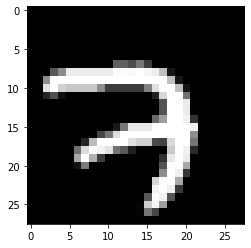

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
mnist = input_data.read_data_sets('/tmp/data/', one_hot=True) #이미지 로딩
#0000100000 -> 4이다. (원핫인코딩 되었기 때문에)
print(mnist.train.images.shape) #55000장이 들어옴 숫자그림

first_image = mnist.train.images[0]
print(mnist.test.images.shape) #10000장의 test 그림
first_image = np.array(first_image, dtype='float') #이미지를 배열로 만들었다.
pixels = first_image.reshape((28,28)) #이미지로 변경되었다. (사이즈 전환)
plt.imshow(pixels, cmap='gray') #흑백이미지로 gray해서 보았음
plt.show()

In [21]:
print(mnist.train.images[0].shape)
print(mnist.train.images.shape)
print(mnist.test.images.shape)

#placeholder - 외부주입변수
#변수 선언(공간확보만 한다.)
x = tf.placeholder(tf.float32, [None,784]) #784 - flatten된것(28*28의 픽셀수)
#바이어스 가중치 출력차수와 같음
#10 인이유는 범주의 갯수가 10이여서(0~9)
W = tf.Variable(tf.zeros([784,10])) #학습되는것
b = tf.Variable(tf.zeros([10])) #학습되는것 - variable에 담긴다. - 초기화 0으로 해주었다.

#얘가 model이 된다. (데이터와 가중치를 곱하는것 +바이어스)
y = tf.nn.softmax(tf.matmul(x,W)+b) #예측값을 가지고 있다. 가중치와 곱해지고 바이어스와 더해지는 사건이 벌어지고 있다.
#activation - softmax사용중 (다중분류기)

y_ = tf.placeholder(tf.float32, [None, 10]) #실제target값

#복잡도로 costfunction을 쓰고있다.
#-가 붙은 이유 : log값의 역수가 확률이 작을 때는 높고 확률이 높을때는 작게 표현하기 위해서
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

#오차에 대하서 학습률을 적용하고, 미분을 구해서 방향을 결정하고 가중에 가감하여 가중치를 학습시킨다.
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy) #cost function을 최소화하는 걸로 학습
shape = mnist.train.images.data.shape
sess = tf.InteractiveSession() #대화형으로 세션을 실행할 수 있도록 하는 명령
tf.global_variables_initializer().run()
for _ in range(1000):
    #횟수 반복문
    batch_xs, batch_ys = mnist.train.next_batch(100) #x,y값 100개를 돌려줌
    sess.run(train_step, feed_dict={x:batch_xs, y_:batch_ys}) #위의 선언만 된 변수에 100개의 값들을 넣어준다.
    #key : data 형태로 데이터를 넣어주어야한다.
    #traing step호출 ->cross 엔트로피 -> y_, y -> x,W,b 순으로 호출된다. (그래프 자료구조로 연결되어있다.)
    #말단의 놈만 호출하면 모든것의 계산이 실행된다.
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1)) #가장큰 확률값의 범주로 채택(인덱스로 리턴)
    #가장큰놈의 범주의 인덱스가 같은지 비교하여 1과 0의 값을 리턴한다.(100개)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #소수점 계산을 위해 타입변환
    print(sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels}))
sess.close()

(784,)
(55000, 784)
(10000, 784)
0.4889
0.4245
0.403
0.4504
0.6295
0.6397
0.7022
0.6643
0.7101
0.6526
0.7162
0.7366
0.7457
0.7281
0.8224
0.8422
0.8246
0.8317
0.8268
0.8463
0.8595
0.8395
0.8594
0.8607
0.8659
0.8638
0.8579
0.8446
0.8471
0.8682
0.8713
0.8721
0.8579
0.8713
0.8604
0.8731
0.8687
0.8688
0.8724
0.8773
0.8773
0.8698
0.8794
0.8818
0.8779
0.8821
0.8769
0.8731
0.8812
0.8754
0.8766
0.8842
0.8833
0.8801
0.8803
0.8793
0.8815
0.8864
0.8728
0.8596
0.8762
0.8796
0.8794
0.8807
0.878
0.8782
0.8873
0.8807
0.8831
0.8802
0.8838
0.8842
0.8843
0.8828
0.8857
0.8737
0.8869
0.8801
0.8834
0.8912
0.887
0.8733
0.8745
0.8881
0.8867
0.8757
0.8899
0.8924
0.8854
0.8924
0.8839
0.8932
0.8928
0.8848
0.8885
0.8901
0.8936
0.8921
0.8932
0.887
0.8936
0.8952
0.8947
0.8933
0.8893
0.8926
0.8966
0.8992
0.8979
0.8938
0.8971
0.8906
0.8941
0.894
0.8937
0.8999
0.9004
0.8984
0.9005
0.8907
0.8965
0.8958
0.8927
0.9007
0.8986
0.9008
0.9009
0.9014
0.8996
0.8921
0.8976
0.9008
0.9007
0.9025
0.9025
0.9048
0.9
0.8993
0.8964
0.